In [1]:
import sqlite3
import pandas
con = sqlite3.connect('coal.db')
plant_labels = pandas.read_sql("select orispl_code, unitid, name, latitude, longitude, county, state, sum(CAST(gload as float)) as total_gen from data group by orispl_code, unitid", con)

In [5]:
year_labels = {}
for year in [2001, 2006, 2011, 2016]:
    year_labels[year] = pandas.read_sql("select orispl_code, unitid, name, latitude, longitude, county, state, sum(CAST(gload as float)) as total_gen from data where year is " + str(year) + " group by orispl_code, unitid", con)

In [3]:
# Step 1: loading data
import csv
import numpy as np
import os.path
to_ml = []
to_plot = []
labels = []
for i, row in plant_labels.iterrows():
    for year in range(2001, 2017):
        file_name = 'cf/' + str(row['orispl_code']) + '_' + row['unitid'] + '_' + str(year) + '.csv'
        if not os.path.isfile(file_name): continue
        with open(file_name, 'rb') as csvfile:
            dr = csv.DictReader(csvfile)
            to_insert = []
            for row in dr:
                to_insert.append(float(row['capacity_factor']))
                if int(row['']) % 24 is 23:
                    to_plot.append(to_insert)
                    to_ml.append(to_insert + np.gradient(to_insert).tolist())
                    labels.append((row['op_date'], row['name'], row['unitid']))
                    to_insert = []

In [6]:
# Step 2: normalize data
from sklearn.preprocessing import normalize
normalized = normalize(to_ml)

In [7]:
# Step 3: run kmeans
clusters = 20
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=clusters, random_state=0).fit(normalized)

In [8]:
output = kmeans.labels_

In [9]:
import shutil
import os.path
if os.path.exists('kmeans_' + str(clusters)):
    shutil.rmtree('kmeans_' + str(clusters))

In [10]:
# Save images to inspect results
import os.path
import matplotlib.pyplot as plt
import random
counts = clusters * [0]
totals = clusters * [np.zeros(24)]
for i in range(clusters):
    if not os.path.exists('kmeans_' + str(clusters)+ '/' + str(i)):
        os.makedirs('kmeans_' + str(clusters) + '/' + str(i))
for i in range(len(normalized)):
    counts[output[i]] += 1
    totals[output[i]] = to_plot[i] + totals[output[i]]
    # Sample .1% of days (~500 total) to verify that clusters are working 
#     if random.randint(1, 1000) is not 100: continue
#     plt.gcf().clear()
#     plt.axis([0, 24, 0, 1])
#     plt.xlabel('Hour')
#     plt.ylabel('Capacity Factor')
#     plt.plot(to_plot[i])
#     plt.title(str(labels[i][1]) + " unit " + str(labels[i][2]) + " operation on " + str(labels[i][0]))
#     plt.savefig('kmeans_' + str(clusters) + '/' + str(output[i]) + '/' + str(labels[i][1]) + '_' + str(labels[i][2]) + '_' + str(labels[i][0]) + '.png')


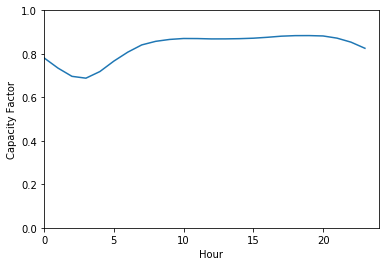

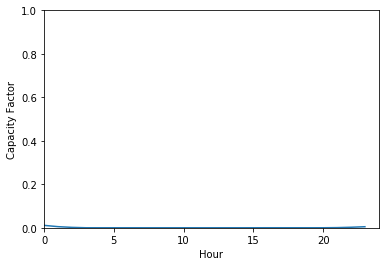

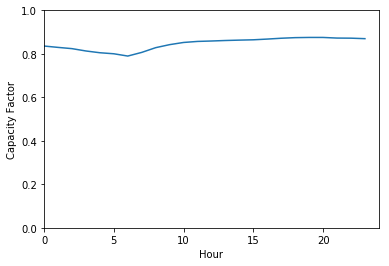

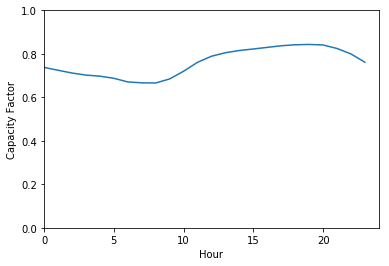

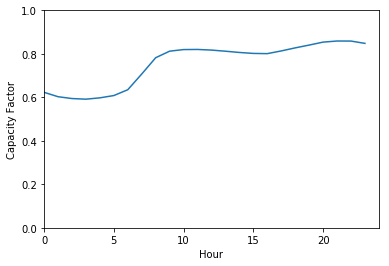

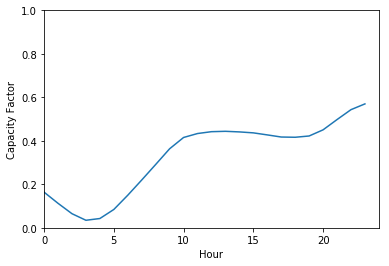

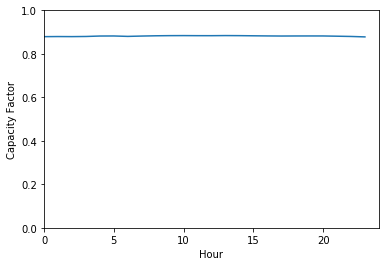

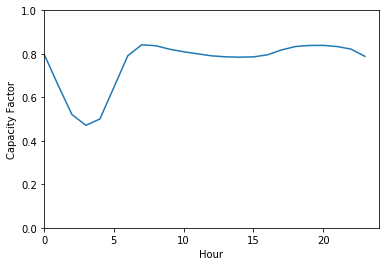

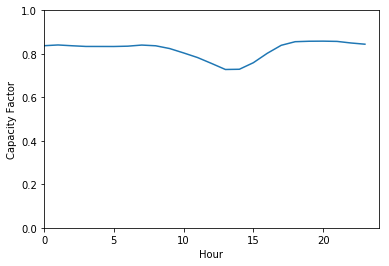

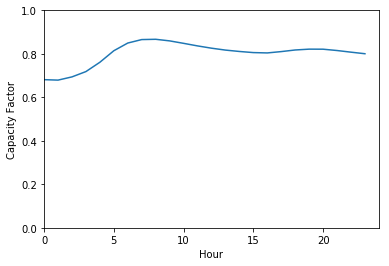

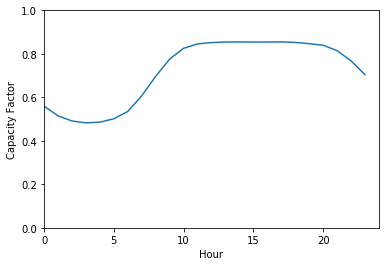

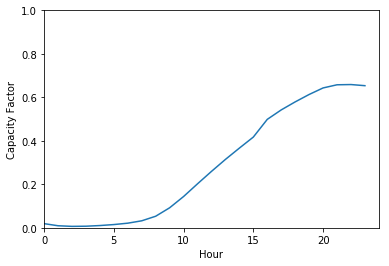

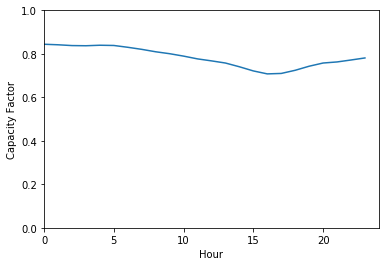

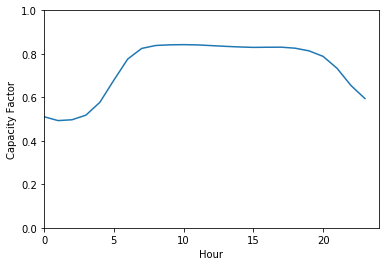

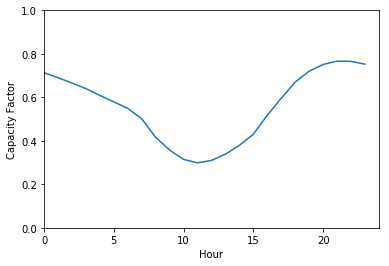

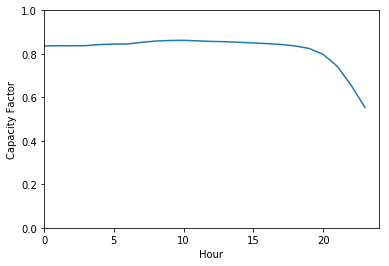

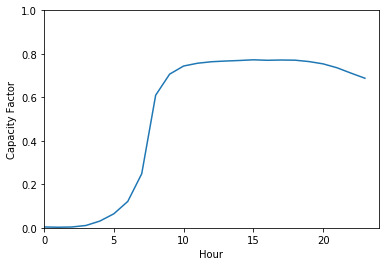

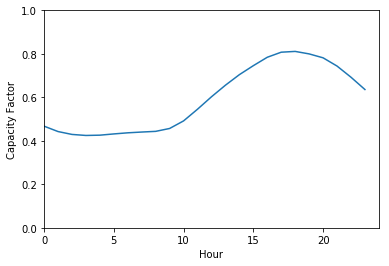

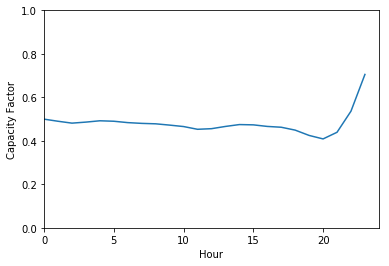

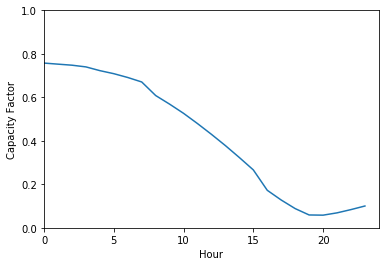

In [140]:
for i in range(clusters):
    values = totals[i] / counts[i]
    plt.gcf().clear()
    plt.axis([0, 24, 0, 1])
    plt.plot(values)
#     plt.title("Cluster " + str(i) + " Average Shape")
    plt.xlabel('Hour')
    plt.ylabel('Capacity Factor')
    plt.savefig('kmeans_' + str(clusters) + '/average' + str(i) + ".png")
    plt.show()


In [13]:
def get_counts(filename):
    to_test = []
    with open(filename, 'rb') as csvfile:
        dr = csv.DictReader(csvfile)
        to_insert = []
        for row in dr:
            to_insert.append(float(row['capacity_factor']))
            if int(row['']) % 24 is 23:
                to_test.append(to_insert + np.gradient(to_insert).tolist())
                to_insert = []
    if to_test == []: return clusters * [0]
    result = kmeans.predict(normalize(to_test))
    counts = clusters * [0]
    for i in range(len(result)):
        counts[result[i]] += 1
    return counts

In [68]:
for entry in get_counts('cf/6481_1SGA_2001.csv'):
    print entry
for entry in get_counts('cf/6481_1SGA_2006.csv'):
    print entry
for entry in get_counts('cf/6481_1SGA_2011.csv'):
    print entry
for entry in get_counts('cf/6481_1SGA_2016.csv'):
    print entry

9
37
71
3
0
0
217
1
3
0
0
6
2
2
2
9
1
0
0
2
5
0
22
1
0
0
291
0
5
15
0
1
3
2
4
14
0
1
0
0
101
47
38
8
10
2
66
3
4
5
44
1
2
22
3
5
0
3
0
1
19
37
20
55
10
1
48
9
6
6
11
2
8
21
25
4
0
82
1
1


In [60]:
def get_year(year):
    to_test = []
    for i, row in plant_labels.iterrows():
        file_name = 'cf/' + str(row['orispl_code']) + '_' + row['unitid'] + '_' + str(year) + '.csv'
        if not os.path.isfile(file_name): continue
        with open(file_name, 'rb') as csvfile:
            dr = csv.DictReader(csvfile)
            to_insert = []
            for row in dr:
                to_insert.append(float(row['capacity_factor']))
                if int(row['']) % 24 is 23:
                    to_test.append(to_insert + np.gradient(to_insert).tolist())
                    to_insert = []
    result = kmeans.predict(normalize(to_test))
    counts = clusters * [0]
    for i in range(len(result)):
        counts[result[i]] += 1
    return counts

def get_plant_year(year, orispl_code):
    to_test = []
    unitids = []
    for i, row in plant_labels.iterrows():
        if row['orispl_code'] == orispl_code:
            unitids.append(row['unitid'])
    for unitid in unitids:
        file_name = 'cf/' + str(orispl_code) + '_' + str(unitid) + '_' + str(year) + '.csv'
        if not os.path.isfile(file_name): continue
        with open(file_name, 'rb') as csvfile:
            dr = csv.DictReader(csvfile)
            to_insert = []
            for row in dr:
                to_insert.append(float(row['capacity_factor']))
                if int(row['']) % 24 is 23:
                    to_test.append(to_insert + np.gradient(to_insert).tolist())
                    to_insert = []
    result = kmeans.predict(normalize(to_test))
    counts = clusters * [0]
    for i in range(len(result)):
        counts[result[i]] += 1
    return counts

def get_unit_year(year, orispl_code, unitid):
    return get_counts('cf/' + str(orispl_code) + '_' + str(unitid) + '_' + str(year) + '.csv')

In [121]:
code = 4941
for year in [2001, 2006, 2011, 2016]:
    for entry in get_plant_year(year, code):
        print entry

97
77
215
25
14
2
536
3
9
9
44
8
14
8
3
16
1
3
1
10
71
79
183
20
13
2
630
0
15
15
0
5
26
4
8
16
0
3
1
4
176
88
165
17
22
1
410
7
31
24
50
10
33
22
1
18
4
6
1
9
219
131
32
205
18
4
20
24
60
56
93
14
23
38
18
21
2
108
0
12


In [33]:
print len(normalized)

535393


In [124]:
code = 4941
unitid = 3
for year in [2001, 2006, 2011, 2016]:
    for entry in get_unit_year(year, code, unitid):
        print entry

22
37
62
10
4
0
193
1
1
1
12
3
5
3
0
5
1
0
0
5
29
32
56
5
4
0
211
0
1
6
0
3
9
1
2
3
0
2
0
1
71
6
53
3
8
0
166
2
6
9
15
3
10
6
0
5
1
1
0
0
71
33
8
62
6
1
11
12
20
20
32
4
7
11
7
8
1
50
0
2


In [36]:
365 * 16

5840

In [116]:
dictionary = {}
for year in range(2001, 2017):
    dictionary[year] =[]
    for i, row in plant_labels.iterrows():
        file_name = 'cf/' + str(row['orispl_code']) + '_' + str(row['unitid']) + '_' + str(year) + '.csv'
        if not os.path.isfile(file_name): continue
        counts = get_counts(file_name)
        if sum(counts) == 0: continue
        percent = float(counts[6])/sum(counts)
        if percent > 0.7 and year > 2010:
            print year, row
        dictionary[year].append(percent)

2011 orispl_code    113
unitid           1
Name: 1, dtype: object
2011 orispl_code    55479
unitid           001
Name: 96, dtype: object
2011 orispl_code    56319
unitid           001
Name: 99, dtype: object
2011 orispl_code    56596
unitid           001
Name: 100, dtype: object
2012 orispl_code    7504
unitid          001
Name: 80, dtype: object
2012 orispl_code    55479
unitid           001
Name: 96, dtype: object
2012 orispl_code    56319
unitid           001
Name: 99, dtype: object
2012 orispl_code    56596
unitid           001
Name: 100, dtype: object
2013 orispl_code    6761
unitid          101
Name: 79, dtype: object
2013 orispl_code    7504
unitid          001
Name: 80, dtype: object
2013 orispl_code    55479
unitid           001
Name: 96, dtype: object
2013 orispl_code    56319
unitid           001
Name: 99, dtype: object
2013 orispl_code    56596
unitid           001
Name: 100, dtype: object
2013 orispl_code    56609
unitid            01
Name: 101, dtype: object
2014 orispl_c

In [102]:
to_csv = {}
field_names = []
field_names.append("Year")
for min_percentage in range(10):
    field_names.append(str(float(min_percentage) / 10) + " <= x < " + str(float(min_percentage + 1) / 10))

for year in dictionary:
    to_csv[year] = {}
    for min_percentage in range(10):
        count = 0
        for entry in dictionary[year]:
            if entry >= float(min_percentage) / 10 and entry < float(min_percentage + 1) / 10:
                count += 1
        to_csv[year][field_names[min_percentage + 1]] = count
    to_csv[year]['Year'] = year
with open('percent_baseload.csv', 'wb') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    for year in to_csv:
        writer.writerow(to_csv[year])

In [14]:
# Making a map visualization
import csv
fieldnames = ['Name', 'Unit ID', 'Latitude', 'Longitude', 'County', '% of days in baseload', 'Generation']
for year in [2001, 2006, 2011, 2016]:
    with open('k-means/baseload_map_' + str(year) + '.csv', 'wb') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i, row in year_labels[year].iterrows():
            file_name = 'cf/' + str(row['orispl_code']) + '_' + str(row['unitid']) + '_' + str(year) + '.csv'
            if not os.path.isfile(file_name): continue
            counts = get_counts(file_name)
            if sum(counts) == 0: continue
            percent = float(counts[6])/sum(counts)
            writer.writerow({'Name':row['name'], 'Unit ID':row['unitid'], 'Latitude':row['latitude'], 'Longitude': row['longitude'], 'County':row['county'] + ", " + row['state'], '% of days in baseload': percent, 'Generation': row['total_gen']})